# 建構生成器 ( 視覺化工具 hidden layer)

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import hiddenlayer as hl
from torch.utils.tensorboard import SummaryWriter

class Generator(nn.Module):
    
    def __init__(self, z_dim, label_dim):

        super(Generator, self).__init__()

        self.input_x = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(z_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # image size =  (1-1)*1 - 2*0 + 4 = 4
        )
        
        self.input_y = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( label_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # image size =  (1-1)*1 - 2*0 + 4 = 4
        )
        
        self.concat = nn.Sequential(
            
            # 因為 x 跟 y 水平合併所以要再乘以 2
            nn.ConvTranspose2d(256*2, 128, 4, 2, 1, bias=False),    
            nn.BatchNorm2d(128),
            nn.ReLU(True),
             # image size =  (4-1)*2 - 2*1 + 4 = 8
            
            nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # image size =  (8-1)*2 - 2*1 + 4 = 16
            
            nn.ConvTranspose2d( 64, 1, 4, 2, 3, bias=False),
            nn.Tanh()
            # image size =  (16-1)*2 - 2*3 + 4 = 28
        )

    def forward(self, x, y):
        
        x = self.input_x(x)
        y = self.input_y(y)
        out = torch.cat([x, y] , dim=1)
        out = self.concat(out)
        return out
    
def print_div(text):
    
    div='\n'
    for i in range(60): div += "="
    div+='\n'
    print("{} {:^60} {}".format(div, text, div))
    
""" Define Generator """
G = Generator(100, 10)

""" Use Print"""
print_div('Print Model Directly')
print(G)

""" Use Torchsummary """
print_div('Print Model With Torchsummary')
test_x = (100, 1, 1)
test_y = (10, 1, 1)
summary(G, [test_x, test_y], batch_size=64)


                     Print Model Directly                     

Generator(
  (input_x): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (input_y): Sequential(
    (0): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (concat): Sequential(
    (0): ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv


                 Print Model With HiddenLayer                 




(dot.exe:14320): Pango-WARNING **: couldn't load font "Times Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(dot.exe:3772): Pango-WARNING **: couldn't load font "Times Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


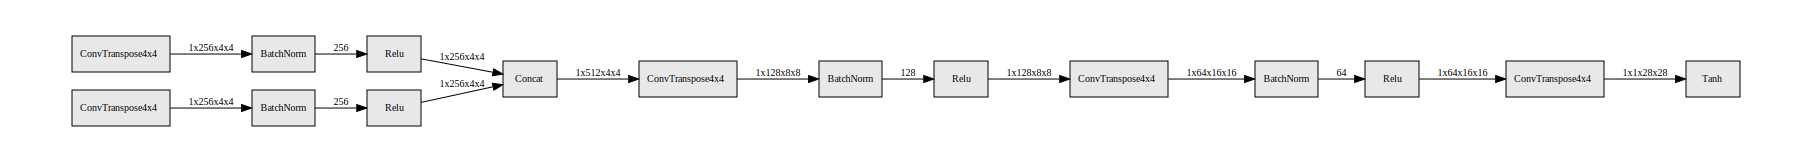

In [10]:
""" Initial Parameters"""
batch_size = 1
test_x = torch.rand(batch_size, 100, 1, 1)
test_y = torch.rand(batch_size, 10, 1, 1)

print_div('Print Model With HiddenLayer')
g_graph = hl.build_graph(G, (test_x, test_y))
g_graph.save('./images/G_grpah', format="jpg")
g_graph

In [12]:
""" Initial Parameters"""
batch_size = 1
test_x = torch.rand(batch_size, 100, 1, 1)
test_y = torch.rand(batch_size, 10, 1, 1)

print_div('Print Model With Tensorboard')
print('open terminal and input "tensorboard --logdir=runs"')
print('open browser and key http://localhost:6006')
writer = SummaryWriter()
writer.add_graph(G, (test_x, test_y))
writer.close()


                 Print Model With Tensorboard                 

open terminal and input "tensorboard --logdir=runs"
open browser and key http://localhost:6006


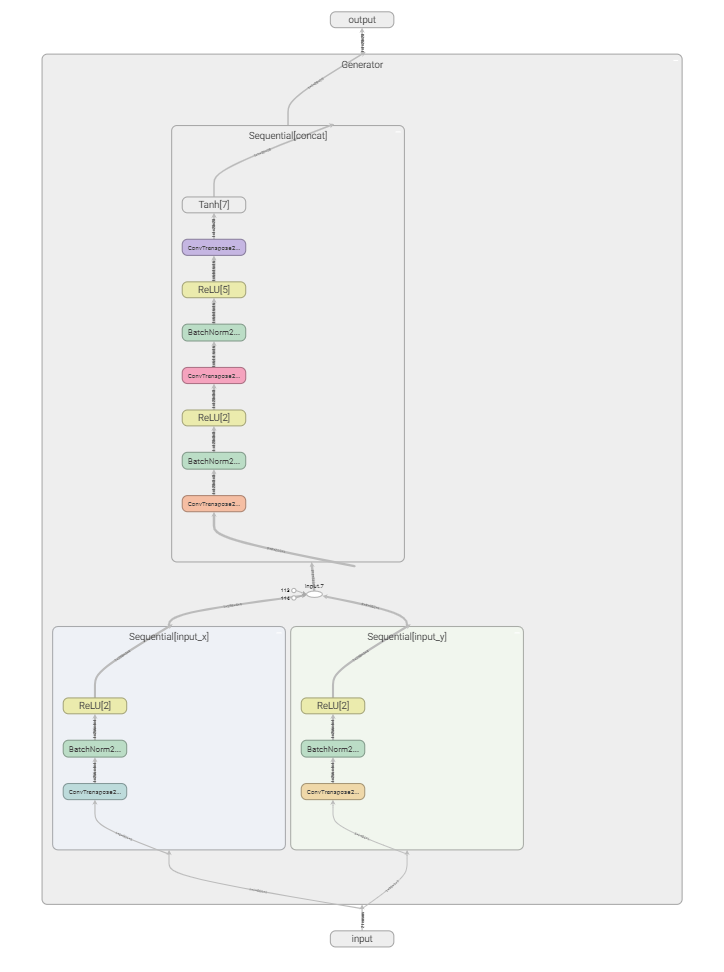

# 建構鑑別器


(dot.exe:4032): Pango-WARNING **: couldn't load font "Times Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


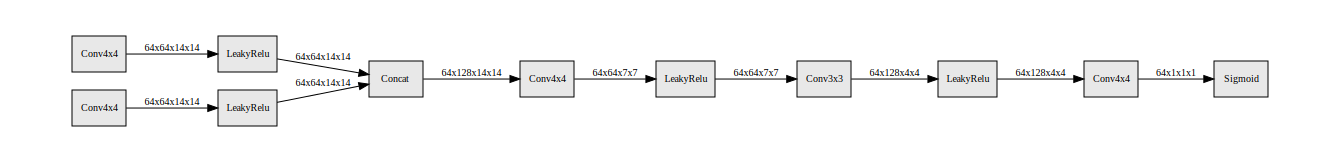

In [13]:
import torch
import torch.nn as nn
from torchsummary import summary

class Discriminator(nn.Module):
    
    def __init__(self, c_dim=1, label_dim=10):
        
        super(Discriminator, self).__init__()

        self.input_x = nn.Sequential(
            
            # Input size = 1 ,28 , 28
            nn.Conv2d(c_dim, 64, (4,4), 2, 1),
            nn.LeakyReLU(),
        )
        self.input_y = nn.Sequential(
            
            # Input size = 10 ,28 , 28
            nn.Conv2d(label_dim, 64, (4,4), 2, 1),
            nn.LeakyReLU(),
        )
        
        self.concate = nn.Sequential(
            
            # Input size = 64+64 ,14 , 14
            nn.Conv2d(64*2 , 64, (4,4), 2, 1),
            nn.LeakyReLU(),
            
            # Input size = (14-4+2)/2 +1 = 7
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(),
            
            # Input size = (7-3+2)/2 +1 = 4
            nn.Conv2d(128, 1, 4, 2, 0),
            nn.Sigmoid(),
            
            # output size = (4-4)/2 +1 = 1
        )
        
    def forward(self, x, y):
        
        x = self.input_x(x)
        y = self.input_y(y)
        out = torch.cat([x, y] , dim=1)
        out = self.concate(out)
        return out
    
D = Discriminator(1, 10)
test_x = torch.rand(64, 1,28,28)
test_y = torch.rand(64, 10,28,28)

writer = SummaryWriter()
writer.add_graph(D, (test_x, test_y))
writer.close()

hl.build_graph(D, (test_x, test_y))

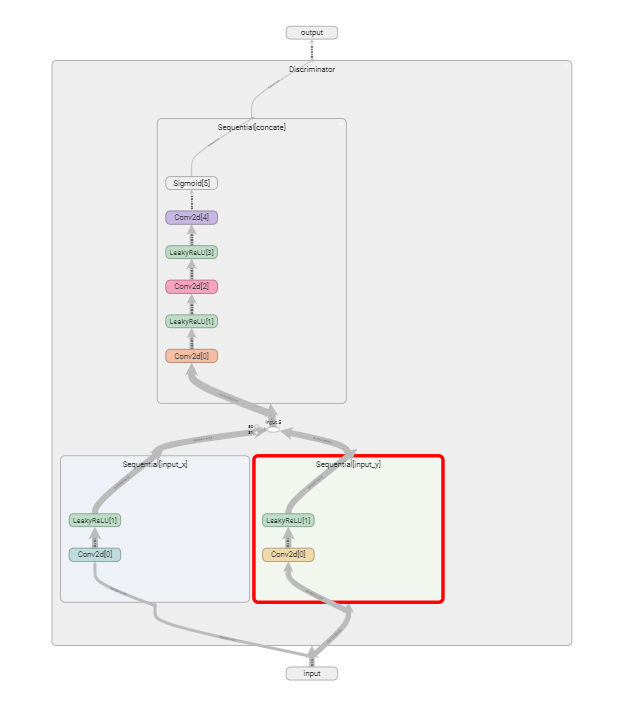

# 數據處理 ( 本篇最難之處 )

我們的目標是

1. 固定一組雜訊來做預測

產生一個 (100, 100, 1, 1) 的雜訊，因為測試圖片通常都是 10*10，
產生 G 對應的標籤，大小為 (100, 10, 1, 1)，10是因為10類別

2. 產生 D 對應的標籤，大小為 (10, 10, 28, 28)

In [65]:
""" OneHot 格式 之 scatter 應用"""
""" 超好理解的圖形化教學 https://medium.com/@yang6367/understand-torch-scatter-b0fd6275331c """

label =torch.tensor([1,5,6,9])
print(label, label.shape)


a = torch.zeros(10).scatter_(0, label, 1)
print(a)

print('\n\n')
label_=label.unsqueeze(1)
print(label_, label_.shape)
b = torch.zeros(4,10).scatter_(1, label_, 1)
print(b)

tensor([1, 5, 6, 9]) torch.Size([4])
tensor([0., 1., 0., 0., 0., 1., 1., 0., 0., 1.])



tensor([[1],
        [5],
        [6],
        [9]]) torch.Size([4, 1])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


In [15]:
label_dim=10
z_dim = 100
image_size=28

""" 產生固定資料，每個類別10張圖(雜訊) 以及 對應的標籤，用於視覺化結果 """
temp_noise = torch.randn(label_dim, z_dim)                   # (10, 100) 10張圖
fixed_noise = temp_noise                          
fixed_c = torch.zeros(label_dim, 1)                          # (10, 1 ) 10個標籤

for i in range(9):
    fixed_noise = torch.cat([fixed_noise, temp_noise], 0)    #將每個類別的十張雜訊依序合併，維度1會自動boardcast
    temp = torch.ones(label_dim, 1) + i                      #依序將標籤對應上 0~9
    fixed_c = torch.cat([fixed_c, temp], 0)                  #將標籤也依序合併

fixed_noise = fixed_noise.view(-1, z_dim, 1, 1)              #由於是捲積所以我們要將形狀轉換成二維的
print('Predict Noise: ', fixed_noise.shape)
print('Predict Label (before): ', fixed_c.shape, '\t\t\t', fixed_c[50])    

""" 針對 lael 做 onehot """
fixed_label = torch.zeros(100, label_dim)                    #先產生 [100,10] 的全0張量，100個標籤，每個標籤維度是 10
fixed_label.scatter_(1, fixed_c.type(torch.LongTensor), 1)   #轉成 onehot編碼 (1, ) -> (10, )
fixed_label = fixed_label.view(-1, label_dim, 1, 1)          #轉換形狀 (10, 1, 1 ) 
print('Predict Label (onehot): ',fixed_label.shape, '\t\t', fixed_label[50].view(1,-1), '\n')

""" 幫標籤做前處理，onehot for g, fill for d """
onehot = torch.zeros(label_dim, label_dim)                   # 產生 (10,10) 10個標籤，維度為10 (onehot)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(label_dim, 1), 1).view(label_dim, label_dim, 1, 1)
print('Train G label:',onehot[1].shape, '\n', onehot[1], '\n')                # 假設我們要取得標籤 1 的 onehot (10,1,1)，直接輸入索引 1

fill = torch.zeros([label_dim, label_dim, image_size, image_size])    # 產生 (10, 10, 28, 28) 意即 10個標籤 維度都是 (10,28,28)
for i in range(label_dim):
    fill[i, i, :, :] = 1                                     # 舉例 標籤 5，第一個[]代表標籤5，第二個[]代表onehot為1的位置 
print('Train D Label: ', fill.shape)                             
print('\n', fill[1].shape, '\n', fill[1])                    # 假設我們要取得標籤 1 的 onehot (10,28,28)

Predict Noise:  torch.Size([100, 100, 1, 1])
Predict Label (before):  torch.Size([100, 1]) 			 tensor([5.])
Predict Label (onehot):  torch.Size([100, 10, 1, 1]) 		 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]) 

Train G label: torch.Size([10, 1, 1]) 
 tensor([[[0.]],

        [[1.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]]]) 

Train D Label:  torch.Size([10, 10, 28, 28])

 torch.Size([10, 28, 28]) 
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1.

# 訓練GAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import torch
import torchvision.datasets as dset
import torchvision.transforms as trans
import time
import matplotlib.pyplot as plt

""" 基本參數 """
epoch = 10
lr = 2e-3
batch = 12
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
z_dim = 100        # latent Space
c_dim = 1          # Image Channel
label_dim = 10     # label 
image_size=28

""" 產生固定資料，每個類別10張圖(雜訊) 以及 對應的標籤，用於視覺化結果 """
temp_noise = torch.randn(label_dim, z_dim)                   # (10, 100) 10張圖
fixed_noise = temp_noise                          
fixed_c = torch.zeros(label_dim, 1)                          # (10, 1 ) 10個標籤

for i in range(9):
    fixed_noise = torch.cat([fixed_noise, temp_noise], 0)    #將每個類別的十張雜訊依序合併，維度1會自動boardcast
    temp = torch.ones(label_dim, 1) + i                      #依序將標籤對應上 0~9
    fixed_c = torch.cat([fixed_c, temp], 0)                  #將標籤也依序合併

fixed_noise = fixed_noise.view(-1, z_dim, 1, 1).to(device)              #由於是捲積所以我們要將形狀轉換成二維的

""" 針對 lael 做 onehot """
fixed_label = torch.zeros(100, label_dim)                    #先產生 [100,10] 的全0張量，100個標籤，每個標籤維度是 10
fixed_label.scatter_(1, fixed_c.type(torch.LongTensor), 1)   #轉成 onehot編碼 (1, ) -> (10, )
fixed_label = fixed_label.view(-1, label_dim, 1, 1).to(device)            #轉換形狀 (10, 1, 1 ) 

""" 幫標籤座前處理 """
onehot = torch.zeros(label_dim, label_dim)                   #
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(label_dim, 1), 1).view(label_dim, label_dim, 1, 1).to(device)  

fill = torch.zeros([label_dim, label_dim, image_size, image_size]).to(device)  
for i in range(label_dim):
    fill[i, i, :, :] = 1

""" 取得數據集以及DataLoader """
transform = trans.Compose([
    trans.ToTensor(),
    trans.Normalize((0.5,),(0.5,)),
])

train_set = dset.MNIST(root='./mnist_data/', 
                       train=True, transform=transform, 
                       download=True)

test_set = dset.MNIST(root='./mnist_data/',
                      train=False, 
                      transform=transform, 
                      download=False)

train_loader = torch.utils.data.DataLoader(
    dataset = train_set,
    batch_size = batch,
    shuffle=True,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_set,
    batch_size = batch,
    shuffle=False        
)

""" 訓練相關 """

D = Discriminator(c_dim, label_dim).to(device)
G = Generator(z_dim, label_dim).to(device)
loss_fn = nn.BCELoss()
D_opt = optim.Adam(D.parameters(), lr= lr)
G_opt = optim.Adam(G.parameters(), lr= lr)
D_avg_loss = []
G_avg_loss = []

img = []
ls_time = []

for i in range(epoch):
    
    start_time = time.time()
    D_loss = []
    G_loss = []
    
    """ 看到很多範例都有手動調整學習率 """
    if epoch == 2:
        G_opt.param_groups[0]['lr'] /= 5
        D_opt.param_groups[0]['lr'] /= 5
    elif epoch == 5:
        G_opt.param_groups[0]['lr'] /= 10
        D_opt.param_groups[0]['lr'] /= 10
    

    for idx, (data, label) in enumerate(train_loader):
        
        """ 訓練 D """
    
        D_opt.zero_grad()
        label = label.to(device)
        x_real = data.to(device)
        y_real = torch.ones(batch, ).to(device)
        c_real = fill[label].to(device)
        
        y_real_predict = D(x_real, c_real).squeeze()        # (-1, 1, 1, 1) -> (-1, )
        d_real_loss = loss_fn(y_real_predict, y_real)
        d_real_loss.backward()

        noise = torch.randn(batch, z_dim, 1, 1, device = device)
        noise_label = (torch.rand(batch, 1) * label_dim).type(torch.LongTensor).squeeze()
        noise_label_onehot = onehot[noise_label].to(device)   #隨機產生label (-1, )

        x_fake = G(noise, noise_label_onehot)       # 生成假圖
        y_fake = torch.zeros(batch, ).to(device)    # 給予標籤 0
        c_fake = fill[noise_label].to(device)       # 轉換成對應的 10,28,28 的標籤
        
        y_fake_predict = D(x_fake, c_fake).squeeze()
        d_fake_loss = loss_fn(y_fake_predict, y_fake)
        d_fake_loss.backward()
        D_opt.step()

        """ 訓練 G """

        G_opt.zero_grad()

        noise = torch.randn(batch, z_dim, 1, 1, device = device)
        noise_label = (torch.rand(batch, 1) * label_dim).type(torch.LongTensor).squeeze()
        noise_label_onehot = onehot[noise_label].to(device)   #隨機產生label (-1, )
        
        x_fake = G(noise, noise_label_onehot)
        #y_fake = torch.ones(batch, ).to(device)    #這邊的 y_fake 跟上述的 y_real 一樣，都是 1  
        c_fake = fill[noise_label].to(device)
        
        y_fake_predict = D(x_fake, c_fake).squeeze()
        g_loss = loss_fn(y_fake_predict, y_real)    #直接用 y_real 更直觀
        g_loss.backward()
        G_opt.step()
        
        D_loss.append(d_fake_loss.item() + d_real_loss.item())
        G_loss.append(g_loss.item())
        
        if idx%(int(len(train_loader)/100))==0:
            with torch.no_grad():
                print("Epoch [{:02}/{}] \t Step[{:05}/{}] \t D_LOSS:{:.6} \t G_LOSS:{:.6}".format(i+1, epoch, idx+1, len(train_loader) , D_loss[idx], G_loss[idx]))
                
                res = G(fixed_noise, fixed_label)
                img.append(make_grid(res, padding=0, normalize=True))
    
    im = img[int(len(train_loader)/100)*(i+1)-1].cpu().detach().numpy().transpose(1,2,0)
    D_avg_loss.append(torch.mean(torch.FloatTensor(D_loss)))
    G_avg_loss.append(torch.mean(torch.FloatTensor(G_loss)))
    
    end_time = time.time()
    cost_time = end_time - start_time
    ls_time.append(cost_time)
    print('Each Epoch Cost :{} s '.format(cost_time))

print('Total Cost Time : {}'.format(sum(ls_time)))

Epoch [01/10] 	 Step[00001/5000] 	 D_LOSS:1.39094 	 G_LOSS:0.809486
Epoch [01/10] 	 Step[00051/5000] 	 D_LOSS:0.709946 	 G_LOSS:7.93648
Epoch [01/10] 	 Step[00101/5000] 	 D_LOSS:3.09166 	 G_LOSS:10.1192
Epoch [01/10] 	 Step[00151/5000] 	 D_LOSS:0.00442203 	 G_LOSS:5.87005
Epoch [01/10] 	 Step[00201/5000] 	 D_LOSS:0.000991868 	 G_LOSS:12.1361
Epoch [01/10] 	 Step[00251/5000] 	 D_LOSS:1.36506 	 G_LOSS:5.94765
Epoch [01/10] 	 Step[00301/5000] 	 D_LOSS:0.00177128 	 G_LOSS:15.8421
Epoch [01/10] 	 Step[00351/5000] 	 D_LOSS:0.000631941 	 G_LOSS:8.47535
Epoch [01/10] 	 Step[00401/5000] 	 D_LOSS:0.00228316 	 G_LOSS:6.58643
Epoch [01/10] 	 Step[00451/5000] 	 D_LOSS:0.00030223 	 G_LOSS:8.51635
Epoch [01/10] 	 Step[00501/5000] 	 D_LOSS:0.000626842 	 G_LOSS:7.00251
Epoch [01/10] 	 Step[00551/5000] 	 D_LOSS:0.00231187 	 G_LOSS:6.56981
Epoch [01/10] 	 Step[00601/5000] 	 D_LOSS:0.00859087 	 G_LOSS:8.11854
Epoch [01/10] 	 Step[00651/5000] 	 D_LOSS:8.59746e-05 	 G_LOSS:9.46738
Epoch [01/10] 	 Step[00701

In [12]:
print('Generate Mnist Sample\n')
print('GPU \t{}'.format(torch.cuda.get_device_name(0)))
print('Epoch\t{}'.format(epoch))
print('Time\t{}s'.format(sum(ls_time)))

Generate Mnist Sample

GPU 	NVIDIA Tegra X1
Epoch	10
Time	10272.578087806702s


# 訓練成果

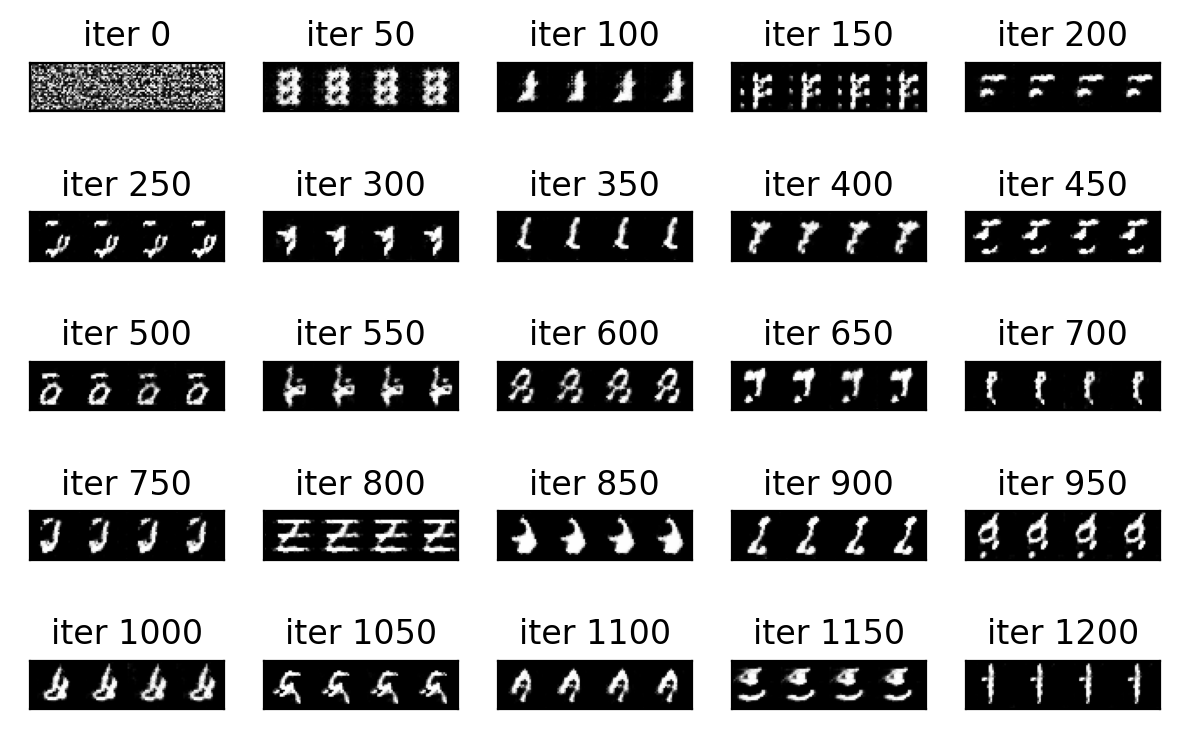

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200)
epoch_num = 10
idx = 50*epoch_num-1
im = img[idx].cpu().detach().numpy().transpose(1,2,0)
plt.title('iter {}'.format(idx) )
plt.imshow(im)
plt.xticks([]), plt.yticks([])
plt.show()

# 製作動畫 (gif or mp4)

In [ ]:
# import matplotlib as mpl 
# mpl.rcParams['animation.ffmpeg_path'] = r'C:\\Users\\xx\\Desktop\\ffmpeg\\bin\\ffmpeg.exe'
from matplotlib import animation

print('Choose file type { 0 : gif, 1 : mp4 } : ', end='')
key = input()
filetype = "gif" if key=='0' else "mp4"

print('Create plt image list', end='......')
fig = plt.figure()
imgs_gif = []
for i in img:
    imgs_gif.append( [plt.imshow(i.cpu().detach().numpy().transpose(1,2,0))] ) 
    #imgs_gif.append( plt.imshow(i.cpu().detach().numpy().transpose(1,2,0)) ) 
save_imgs = imgs_gif[::100]

file_name = r'./cdcgan_mnist_{}{}{}_{}{}.{}'.format(time.localtime()[0],time.localtime()[1],time.localtime()[2],
                                                 time.localtime()[3],time.localtime()[4],
                                                 filetype)
print('done')

print('total frame is: ', len(save_imgs), '\n')

print('Define writer', end='......')
writergif = animation.PillowWriter(fps=30) 
writervideo = animation.FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])
writer = writergif if key=='0' else writervideo
print('done')

print('Create animation', end='......') 
ani = animation.ArtistAnimation(fig, save_imgs, interval=50, blit=True,
                                repeat_delay=1000)
print('done')


print('Save {} file ({}) '.format(filetype, file_name), end='......')
ani.save(file_name, writer=writer)
print('done')

plt.show()